In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import copy
import os


In [2]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

INITIAL_BALANCE = 1000.0
NUM_PAST_STATES = 4
EPISODE_LENGTH = 38 - NUM_PAST_STATES


class TradeEnv(gym.Env):
    def __init__(self, tickers):
        super(TradeEnv, self).__init__()

        self.tickers = tickers
        self.df_list = pickle.load(open('df_list', 'rb'))
        self.total = pd.concat(self.df_list)
        
        self.means = np.mean(self.total[tickers].values, axis = 0)
        self.stds = np.std(self.total[tickers].values, axis = 0)

        self.episode_length = EPISODE_LENGTH #number of trading minutes in episode

        self.num_past_states = NUM_PAST_STATES #number of past days that are used in state

        self.action_space = spaces.Box(low=-10, high=10, shape=(len(self.tickers) + 1,))
                                            

        obs_length = len(self.tickers)*self.num_past_states #observation due to past stacked states
        obs_length += 1 #balance
        obs_length += len(self.tickers) #holdings
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(obs_length,))
        
        
  
    def step(self, action_):
        action = softmax(action_)
        
        
        self.balance += np.sum(self.holdings)

        self.holdings = self.balance*action[:-1]
        self.balance = self.balance*action[-1]
        
        self.last_net_worth = self.balance + np.sum(self.holdings)

        self.index += 1

        stock_obs = self.get_stock_obs(self.index)
        self.next_prices = stock_obs[-1]
        perc_change = np.divide(self.next_prices, self.curr_prices)
        self.holdings = np.multiply(self.holdings, perc_change)
        
        self.curr_prices = self.next_prices
        

        self.net_worth = self.balance + np.sum(self.holdings)


        rew = self.net_worth - self.last_net_worth # reward is the delta between last net worth and current net worth

        done = (self.net_worth <= 0) or (self.steps > self.episode_length)
        self.steps += 1

        
        obs = self.get_obs(stock_obs, self.balance, self.holdings)

        
    
        
        
        obs = self.get_obs(self.normalize_stock_obs(stock_obs), self.balance/1000.0, self.holdings/1000.0)

        return obs, 200.0*rew, done, {}
    
    def normalize_stock_obs(self, stock_obs):
        return np.divide(stock_obs - self.means, self.stds)
    
    def get_stock_obs(self, index):

        
        return self.data[index - self.num_past_states:index][self.tickers].values #stack data

    def get_obs(self, stock_obs, balance, holdings):
        return np.concatenate([stock_obs.reshape(-1,), [balance], holdings])
        
    def reset(self):
        df_idx = np.random.randint(len(self.df_list))
        self.data = self.df_list[df_idx]
        self.steps = 0
        self.index = NUM_PAST_STATES
        
        stock_obs = self.get_stock_obs(self.index)
        self.holdings = np.zeros(len(self.tickers)) #holdings of each stock in number of shares
        self.balance = INITIAL_BALANCE
        self.last_net_worth = INITIAL_BALANCE
        
        

        self.curr_prices = stock_obs[-1]

        obs = self.get_obs(self.normalize_stock_obs(stock_obs), self.balance/1000.0, self.holdings/1000.0)
        return obs  # reward, done, info can't be included



In [3]:

tickers = ['LLL', 'DIS', 'WM', 'BRK.B', 'FTI']

In [4]:
env = TradeEnv(tickers=tickers)

In [5]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.callbacks import BaseCallback

In [6]:
class SaveRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:

        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

In [7]:
log_dir = "intra_tmp/"
os.makedirs(log_dir, exist_ok=True)

In [8]:
trade_env = TradeEnv(tickers=tickers)
env = Monitor(trade_env, log_dir)

In [9]:
callback = SaveRewardCallback(check_freq=10000, log_dir=log_dir)

In [10]:
import torch as th
# policy_kwargs = dict(activation_fn=th.nn.Tanh,
#                      net_arch=[dict(pi=[96, 128, 64], vf=[96, 64, 64])])

policy_kwargs = dict(net_arch=[dict(vf=[256, 128, 64], pi=[256, 256, 128])])

In [13]:
model = PPO('MlpPolicy', env, gamma = 1.0, verbose=1)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [112]:
model.learning_rate = .004

In [113]:
model.learn(total_timesteps=int(5e7), callback = callback, log_interval = 50)

Num timesteps: 3245
Best mean reward: 1474.71 - Last mean reward per episode: 512.73
Num timesteps: 13245
Best mean reward: 1474.71 - Last mean reward per episode: 549.63
Num timesteps: 23245
Best mean reward: 1474.71 - Last mean reward per episode: 838.38
Num timesteps: 33245
Best mean reward: 1474.71 - Last mean reward per episode: 397.65
Num timesteps: 43245
Best mean reward: 1474.71 - Last mean reward per episode: 1129.22
Num timesteps: 53245
Best mean reward: 1474.71 - Last mean reward per episode: 234.41
Num timesteps: 63245
Best mean reward: 1474.71 - Last mean reward per episode: 905.72
Num timesteps: 73245
Best mean reward: 1474.71 - Last mean reward per episode: 716.56
Num timesteps: 83245
Best mean reward: 1474.71 - Last mean reward per episode: 947.58
Num timesteps: 93245
Best mean reward: 1474.71 - Last mean reward per episode: 977.59
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 36           |
|    ep_rew

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 36           |
|    ep_rew_mean          | 588          |
| time/                   |              |
|    fps                  | 716          |
|    iterations           | 250          |
|    time_elapsed         | 715          |
|    total_timesteps      | 512000       |
| train/                  |              |
|    approx_kl            | 0.0081161605 |
|    clip_fraction        | 0.0437       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.48        |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.39e+03     |
|    n_updates            | 106890       |
|    policy_gradient_loss | -0.00545     |
|    std                  | 0.722        |
|    value_loss           | 1.4e+04      |
------------------------------------------
Num timesteps: 513245
Best mean reward: 1474.71 - Last

Num timesteps: 923245
Best mean reward: 1474.71 - Last mean reward per episode: 884.74
Num timesteps: 933245
Best mean reward: 1474.71 - Last mean reward per episode: 1112.92
Num timesteps: 943245
Best mean reward: 1474.71 - Last mean reward per episode: 859.77
Num timesteps: 953245
Best mean reward: 1474.71 - Last mean reward per episode: 617.93
Num timesteps: 963245
Best mean reward: 1474.71 - Last mean reward per episode: 799.80
Num timesteps: 973245
Best mean reward: 1474.71 - Last mean reward per episode: 1162.96
Num timesteps: 983245
Best mean reward: 1474.71 - Last mean reward per episode: 737.42
Num timesteps: 993245
Best mean reward: 1474.71 - Last mean reward per episode: 846.69
Num timesteps: 1003245
Best mean reward: 1474.71 - Last mean reward per episode: 832.16
Num timesteps: 1013245
Best mean reward: 1474.71 - Last mean reward per episode: 829.14
Num timesteps: 1023245
Best mean reward: 1474.71 - Last mean reward per episode: 701.22
--------------------------------------

Num timesteps: 1423245
Best mean reward: 1551.89 - Last mean reward per episode: 728.79
Num timesteps: 1433245
Best mean reward: 1551.89 - Last mean reward per episode: 1021.64
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 36           |
|    ep_rew_mean          | 1.05e+03     |
| time/                   |              |
|    fps                  | 734          |
|    iterations           | 700          |
|    time_elapsed         | 1952         |
|    total_timesteps      | 1433600      |
| train/                  |              |
|    approx_kl            | 0.0057401666 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.3         |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.41e+03     |
|    n_updates            | 111390       |
|    policy_gradient_loss | -0.00336     |
|    s

Num timesteps: 1843245
Best mean reward: 1551.89 - Last mean reward per episode: 554.80
Num timesteps: 1853245
Best mean reward: 1551.89 - Last mean reward per episode: 721.52
Num timesteps: 1863245
Best mean reward: 1551.89 - Last mean reward per episode: 1123.85
Num timesteps: 1873245
Best mean reward: 1551.89 - Last mean reward per episode: 893.91
Num timesteps: 1883245
Best mean reward: 1551.89 - Last mean reward per episode: 684.04
Num timesteps: 1893245
Best mean reward: 1551.89 - Last mean reward per episode: 773.81
Num timesteps: 1903245
Best mean reward: 1551.89 - Last mean reward per episode: 1120.79
Num timesteps: 1913245
Best mean reward: 1551.89 - Last mean reward per episode: 915.97
Num timesteps: 1923245
Best mean reward: 1551.89 - Last mean reward per episode: 1073.12
Num timesteps: 1933245
Best mean reward: 1551.89 - Last mean reward per episode: 1063.95
Num timesteps: 1943245
Best mean reward: 1551.89 - Last mean reward per episode: 673.56
----------------------------

Num timesteps: 2353245
Best mean reward: 1551.89 - Last mean reward per episode: 646.26
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36          |
|    ep_rew_mean          | 695         |
| time/                   |             |
|    fps                  | 736         |
|    iterations           | 1150        |
|    time_elapsed         | 3197        |
|    total_timesteps      | 2355200     |
| train/                  |             |
|    approx_kl            | 0.006688437 |
|    clip_fraction        | 0.0215      |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.14       |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.76e+03    |
|    n_updates            | 115890      |
|    policy_gradient_loss | -0.00505    |
|    std                  | 0.688       |
|    value_loss           | 6.13e+03    |
------------------------------

Num timesteps: 2773245
Best mean reward: 1551.89 - Last mean reward per episode: 833.25
Num timesteps: 2783245
Best mean reward: 1551.89 - Last mean reward per episode: 637.31
Num timesteps: 2793245
Best mean reward: 1551.89 - Last mean reward per episode: 1115.78
Num timesteps: 2803245
Best mean reward: 1551.89 - Last mean reward per episode: 864.77
Num timesteps: 2813245
Best mean reward: 1551.89 - Last mean reward per episode: 1506.98
Num timesteps: 2823245
Best mean reward: 1551.89 - Last mean reward per episode: 785.47
Num timesteps: 2833245
Best mean reward: 1551.89 - Last mean reward per episode: 781.11
Num timesteps: 2843245
Best mean reward: 1551.89 - Last mean reward per episode: 935.24
Num timesteps: 2853245
Best mean reward: 1551.89 - Last mean reward per episode: 700.89
Num timesteps: 2863245
Best mean reward: 1551.89 - Last mean reward per episode: 880.07
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 36  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 36           |
|    ep_rew_mean          | 1.37e+03     |
| time/                   |              |
|    fps                  | 730          |
|    iterations           | 1600         |
|    time_elapsed         | 4482         |
|    total_timesteps      | 3276800      |
| train/                  |              |
|    approx_kl            | 0.0021060398 |
|    clip_fraction        | 0.00737      |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.98        |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.22e+03     |
|    n_updates            | 120390       |
|    policy_gradient_loss | -0.000859    |
|    std                  | 0.673        |
|    value_loss           | 1.09e+04     |
------------------------------------------
Num timesteps: 3283245
Best mean reward: 1551.89 - Las

Num timesteps: 3693245
Best mean reward: 1551.89 - Last mean reward per episode: 637.95
Num timesteps: 3703245
Best mean reward: 1551.89 - Last mean reward per episode: 968.42
Num timesteps: 3713245
Best mean reward: 1551.89 - Last mean reward per episode: 1106.66
Num timesteps: 3723245
Best mean reward: 1551.89 - Last mean reward per episode: 697.66
Num timesteps: 3733245
Best mean reward: 1551.89 - Last mean reward per episode: 683.01
Num timesteps: 3743245
Best mean reward: 1551.89 - Last mean reward per episode: 1025.70
Num timesteps: 3753245
Best mean reward: 1551.89 - Last mean reward per episode: 960.50
Num timesteps: 3763245
Best mean reward: 1551.89 - Last mean reward per episode: 860.45
Num timesteps: 3773245
Best mean reward: 1551.89 - Last mean reward per episode: 709.62
Num timesteps: 3783245
Best mean reward: 1551.89 - Last mean reward per episode: 903.83
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36    

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 36         |
|    ep_rew_mean          | 1.04e+03   |
| time/                   |            |
|    fps                  | 730        |
|    iterations           | 2050       |
|    time_elapsed         | 5744       |
|    total_timesteps      | 4198400    |
| train/                  |            |
|    approx_kl            | 0.00621258 |
|    clip_fraction        | 0.0277     |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.66      |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.96e+03   |
|    n_updates            | 124890     |
|    policy_gradient_loss | -0.0046    |
|    std                  | 0.641      |
|    value_loss           | 6.62e+03   |
----------------------------------------
Num timesteps: 4203245
Best mean reward: 1640.03 - Last mean reward per episode: 644.94
Num timest

Num timesteps: 4613245
Best mean reward: 1640.03 - Last mean reward per episode: 1131.29
Num timesteps: 4623245
Best mean reward: 1640.03 - Last mean reward per episode: 942.40
Num timesteps: 4633245
Best mean reward: 1640.03 - Last mean reward per episode: 1028.93
Num timesteps: 4643245
Best mean reward: 1640.03 - Last mean reward per episode: 967.79
Num timesteps: 4653245
Best mean reward: 1640.03 - Last mean reward per episode: 1033.78
Num timesteps: 4663245
Best mean reward: 1640.03 - Last mean reward per episode: 1260.75
Num timesteps: 4673245
Best mean reward: 1640.03 - Last mean reward per episode: 969.39
Num timesteps: 4683245
Best mean reward: 1640.03 - Last mean reward per episode: 803.67
Num timesteps: 4693245
Best mean reward: 1640.03 - Last mean reward per episode: 952.52
Num timesteps: 4703245
Best mean reward: 1640.03 - Last mean reward per episode: 598.79
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 36           |
|    ep_rew_mean          | 620          |
| time/                   |              |
|    fps                  | 727          |
|    iterations           | 2500         |
|    time_elapsed         | 7035         |
|    total_timesteps      | 5120000      |
| train/                  |              |
|    approx_kl            | 0.0045430087 |
|    clip_fraction        | 0.0346       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.37        |
|    explained_variance   | 0.997        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.06e+03     |
|    n_updates            | 129390       |
|    policy_gradient_loss | -0.00567     |
|    std                  | 0.615        |
|    value_loss           | 6.44e+03     |
------------------------------------------
Num timesteps: 5123245
Best mean reward: 1640.03 - Las

Num timesteps: 5533245
Best mean reward: 1640.03 - Last mean reward per episode: 1193.78
Num timesteps: 5543245
Best mean reward: 1640.03 - Last mean reward per episode: 919.58
Num timesteps: 5553245
Best mean reward: 1640.03 - Last mean reward per episode: 469.19
Num timesteps: 5563245
Best mean reward: 1640.03 - Last mean reward per episode: 837.15
Num timesteps: 5573245
Best mean reward: 1640.03 - Last mean reward per episode: 802.34
Num timesteps: 5583245
Best mean reward: 1640.03 - Last mean reward per episode: 1223.28
Num timesteps: 5593245
Best mean reward: 1640.03 - Last mean reward per episode: 894.70
Num timesteps: 5603245
Best mean reward: 1640.03 - Last mean reward per episode: 510.57
Num timesteps: 5613245
Best mean reward: 1640.03 - Last mean reward per episode: 803.19
Num timesteps: 5623245
Best mean reward: 1640.03 - Last mean reward per episode: 922.28
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 36  

Num timesteps: 6033245
Best mean reward: 1640.03 - Last mean reward per episode: 1317.68
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 36           |
|    ep_rew_mean          | 1.06e+03     |
| time/                   |              |
|    fps                  | 724          |
|    iterations           | 2950         |
|    time_elapsed         | 8337         |
|    total_timesteps      | 6041600      |
| train/                  |              |
|    approx_kl            | 0.0077681458 |
|    clip_fraction        | 0.0423       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.04        |
|    explained_variance   | 0.996        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.18e+03     |
|    n_updates            | 133890       |
|    policy_gradient_loss | -0.00571     |
|    std                  | 0.587        |
|    value_loss           | 9.76e+03     |
--------

Num timesteps: 6453245
Best mean reward: 1640.03 - Last mean reward per episode: 800.21
Num timesteps: 6463245
Best mean reward: 1640.03 - Last mean reward per episode: 865.11
Num timesteps: 6473245
Best mean reward: 1640.03 - Last mean reward per episode: 879.60
Num timesteps: 6483245
Best mean reward: 1640.03 - Last mean reward per episode: 1108.52
Num timesteps: 6493245
Best mean reward: 1640.03 - Last mean reward per episode: 1210.01
Num timesteps: 6503245
Best mean reward: 1640.03 - Last mean reward per episode: 810.87
Num timesteps: 6513245
Best mean reward: 1640.03 - Last mean reward per episode: 966.83
Num timesteps: 6523245
Best mean reward: 1640.03 - Last mean reward per episode: 1246.41
Num timesteps: 6533245
Best mean reward: 1640.03 - Last mean reward per episode: 1353.36
Num timesteps: 6543245
Best mean reward: 1640.03 - Last mean reward per episode: 771.07
Num timesteps: 6553245
Best mean reward: 1640.03 - Last mean reward per episode: 647.15
----------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36          |
|    ep_rew_mean          | 968         |
| time/                   |             |
|    fps                  | 725         |
|    iterations           | 3400        |
|    time_elapsed         | 9600        |
|    total_timesteps      | 6963200     |
| train/                  |             |
|    approx_kl            | 0.008372452 |
|    clip_fraction        | 0.0552      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.79       |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.89e+03    |
|    n_updates            | 138390      |
|    policy_gradient_loss | -0.0047     |
|    std                  | 0.57        |
|    value_loss           | 6.67e+03    |
-----------------------------------------
Num timesteps: 6963245
Best mean reward: 1640.03 - Last mean reward per epis

Num timesteps: 7373245
Best mean reward: 1640.03 - Last mean reward per episode: 727.43
Num timesteps: 7383245
Best mean reward: 1640.03 - Last mean reward per episode: 818.32
Num timesteps: 7393245
Best mean reward: 1640.03 - Last mean reward per episode: 775.38
Num timesteps: 7403245
Best mean reward: 1640.03 - Last mean reward per episode: 294.53
Num timesteps: 7413245
Best mean reward: 1640.03 - Last mean reward per episode: 1358.23
Num timesteps: 7423245
Best mean reward: 1640.03 - Last mean reward per episode: 695.98
Num timesteps: 7433245
Best mean reward: 1640.03 - Last mean reward per episode: 902.39
Num timesteps: 7443245
Best mean reward: 1640.03 - Last mean reward per episode: 798.72
Num timesteps: 7453245
Best mean reward: 1640.03 - Last mean reward per episode: 1043.43
Num timesteps: 7463245
Best mean reward: 1640.03 - Last mean reward per episode: 1077.47
Num timesteps: 7473245
Best mean reward: 1640.03 - Last mean reward per episode: 1056.43
----------------------------

Num timesteps: 7883245
Best mean reward: 1719.86 - Last mean reward per episode: 1151.77
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36          |
|    ep_rew_mean          | 866         |
| time/                   |             |
|    fps                  | 727         |
|    iterations           | 3850        |
|    time_elapsed         | 10842       |
|    total_timesteps      | 7884800     |
| train/                  |             |
|    approx_kl            | 0.008410096 |
|    clip_fraction        | 0.0565      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.44       |
|    explained_variance   | 0.998       |
|    learning_rate        | 0.0003      |
|    loss                 | 836         |
|    n_updates            | 142890      |
|    policy_gradient_loss | -0.00134    |
|    std                  | 0.546       |
|    value_loss           | 4.23e+03    |
-----------------------------

KeyboardInterrupt: 

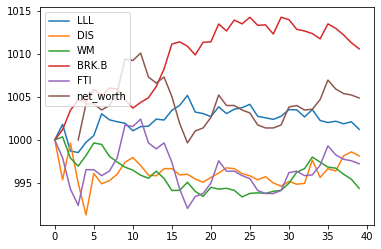

In [111]:
trade_env = TradeEnv(tickers=tickers)
obs = trade_env.reset()
index = trade_env.index
done = False
net_worth = [trade_env.balance]
holdings = [obs[-6:]]
actions = []
while not done:
    action = model.predict(obs, deterministic = False)[0] 
    actions.append(action)
    obs, _, done, _ = trade_env.step(action)
    net_worth.append(trade_env.net_worth)
    holdings.append(obs[-6:])
    
df = trade_env.data

for key in df.keys():
    plt.plot(df.index, 1000.0*df[key]/df.loc[0, key], label = key)
plt.plot(np.arange(len(net_worth)) + 3, net_worth, label = 'net_worth')
plt.legend()
actions = np.array(actions)


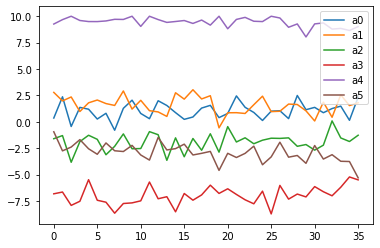

In [109]:
for i in range(6):
    plt.plot(np.arange(len(actions)), actions[:,i], label = 'a{}'.format(i))
plt.legend()

In [37]:
plt.plot(len(n))

40

In [391]:
arr = df[200:230][tickers].values

In [424]:
balance = 1000.0
holdings = np.zeros(len(tickers))
hold_cash = False
for i in range(29):
    if i == 0 or hold_cash:
        balance = 1000.0
    else:
        balance = np.dot(holdings, arr[i])
    holdings = np.zeros(len(tickers))
    perc_inc = np.divide(arr[i+1] - arr[i], arr[i])
    if np.max(perc_inc) > 0:
        idx = np.argmax(perc_inc)
        holdings[idx] += balance/arr[i][idx]
        hold_cash = False
    else:
        hold_cash = True
    print (balance, holdings)
    
    
        

1000.0 [0.         2.91721511 0.         0.         0.        ]
1075.3154672968517 [0.         0.         1.73844193 0.         0.        ]
1289.9219070677075 [0.         4.63076049 0.         0.         0.        ]
1603.5601503834052 [3.39950433 0.         0.         0.         0.        ]
1761.698610802555 [3.39950433 0.         0.         0.         0.        ]
2012.257635717981 [0.        7.2229094 0.        0.        0.       ]
2526.073796749632 [0.         0.         4.70346114 0.         0.        ]
3145.653309069966 [0.         0.         0.         0.         6.02761546]
3912.761368049932 [ 0.         14.03494135  0.          0.          0.        ]
4956.070609392556 [0.         0.         0.         0.         9.41441461]
6094.211657096649 [ 0.          0.          0.         13.33043235  0.        ]
6218.380236217108 [ 0.         22.27719023  0.          0.          0.        ]
7940.820914839412 [16.71203385  0.          0.          0.          0.        ]
8694.159391181654 

In [405]:
arr

array([[560.16479637, 342.79268526, 704.87633664, 545.53959789,
        600.84992606],
       [594.30388253, 368.61027654, 618.55127193, 520.73458222,
        591.79635869],
       [528.4260227 , 278.5550907 , 741.99884645, 542.50774401,
        565.79206459],
       [471.70410605, 346.28440736, 635.43103391, 518.56988114,
        582.58603904],
       [518.22219961, 367.19192545, 607.01785161, 448.16028293,
        556.01961597],
       [591.92677554, 278.59378042, 662.81233043, 497.21509162,
        545.34508791],
       [571.96149444, 349.73078802, 537.06700657, 539.13800242,
        597.28111478],
       [491.83617935, 365.66753092, 668.79542814, 456.74815145,
        521.87358806],
       [484.20325771, 278.78715497, 669.05960483, 436.31169961,
        649.13918151],
       [562.24905614, 353.12371367, 659.09377898, 476.67604727,
        526.43428346],
       [597.96298222, 364.04357003, 790.27902923, 457.1653416 ,
        647.32773195],
       [533.09657289, 279.13664929, 660.195